In [5]:
# !pip install import-ipynb
# !pip install qiskit
# !pip install qiskit_experiments
# !pip install kaleidoscope
# !pip install qiskit_aer
# !pip install qiskit-ibm-runtime
# !pip install qiskit_experiments

In [1]:
# !pip install qiskit[all]

In [2]:
# Save an IBM Quantum account and set it as your default account.
# # from qiskit import  IBMQ
# from qiskit_ibm_runtime import QiskitRuntimeService
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="1e7899e5ebeb70c33a765ac7b32ee37418f75c2abc66f05ce0317d0941089d63116b8c734f889abcc946794276ef328d8af2ebc2e77848450c1f68ee22dc0dbe", set_as_default=True,overwrite=True)
 
# # Load saved credentials
# service = QiskitRuntimeService()

## Importación de Librerías

In [3]:
# # Importing standard Qiskit libraries
# from qiskit import  IBMQ

from qiskit import *
# # Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
service = QiskitRuntimeService()
# Import Qiskit classes
from qiskit import *
import qiskit.quantum_info as qi
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
# from qiskit.providers.aer import noise
import statsmodels.api as sm
#LIBRERÍAS PARA TODO LO NECESARIO: 
#!pip install qiskit ipywidgets    correr esta línea de primero si se trabaja en google collab

#Tomografía de estado 
from qiskit_experiments.library import StateTomography
## Simuladores 
from qiskit_aer import AerSimulator, qasm_simulator
from qiskit.providers.fake_provider import *



from matplotlib import *
%matplotlib inline

#Se importan clases y funciones necesarias para la tomografía
import qiskit.quantum_info as qi
from qiskit.compiler import assemble
import numpy as np 

# Librerías estandar de qiskit
from qiskit.compiler import transpile, assemble
# from qiskit.tools.jupyter import *
# from qiskit.tools.monitor import job_monitor
# from qiskit.visualization import *
# from ibm_quantum_widgets import *
from qiskit.quantum_info import Operator, Choi,Chi,process_fidelity,state_fidelity
# from qiskit.extensions import Initialize
import import_ipynb
# from qiskit.tools.visualization import plot_state_city
import pandas as pd 

# import funciones_tesis as funcs
from Funciones_tessis import *
from qiskit_experiments.library.tomography.qpt_experiment import ProcessTomography, ProcessTomographyAnalysis
# from funciones_tesis import *
#Para dibujar sobre la esfera de bloch
# from kaleidoscope import bloch_sphere
#Extración
import scipy
from scipy.stats import lognorm
import scipy.stats as stats
import re 
import collections as colect
import matplotlib.pyplot as plt
# from kaleidoscope import bloch_sphere
import seaborn as sns

from qiskit_aer.noise import depolarizing_error

## Designación de Ansatz para implementación de canales cuánticos en CC
Para implementar un canal cuántico utilizando Algoritmos Variacionales Cuánticos (VQA), proponemos implementar el el ansatz usado en el trabajo previo de prácticas (https://arxiv.org/pdf/2001.02552.pdf, https://arxiv.org/pdf/1905.10876.pdf. ). 

Este ansatz supone un conjunto de rotaciones $Rx,Rz y Cry$ que pueden ser optimizadas para resolver distintos problemas relacionados a información y computación cuántica. Por lo tanto, aquí buscamos optimizar el ansatz de forma que su acción sobre un estado $\rho$ sea similar al de un canal cuántico objetivo. 

Para realizar esta optimización, proponemos una función de costo $c(\theta) = Fidelidadproceso ( \Lambda_{obj} , \Lambda_{rec})$ , donde $\Lambda$ se le conoce como al matriz de Choi perteneciente al canal cuántico a evaluar. Esta matriz se construye aplicando el canal cuántico a un subsistema del  estado máximamente entrelazado según la dimensión del canal. Se describe por la ecuación :

<img src="choi_def.png">

Por ende, para obtener la matriz de Choi de un canal cuántico de un qubit, tenemos $\Lambda_\epsilon$ =  $(\mathbb{I} \otimes \epsilon)[| \phi^+\geq \leq \phi^+|   ]  $.

Al tener este concepto claro y la función de costo definida, procedemos a ejecutar tomografía de proceso usando el ansatz aplicado a un subsistema del estado máximamente entrelazado, posteriormente se optimiza iterativamente la función de costo hasta obtener una Fidelidad de Proceso cercana a 1. Todo este proceso constituye un VQA. Sin embargo, por motivos de eficiente y cola de uso, se hizo esta optimizaicón en el simulador cuántico Qiskit AerSimulator. 

### Visualización del Ansatz a Optimizar

In [9]:
qc= QuantumCircuit(4)
# qc.h(0)
# qc.cx(0, 1)
# qc.barrier(0,1,2,3)
qc_combo = cirq_ansq(2,np.linspace(1,16,16),1)[0]

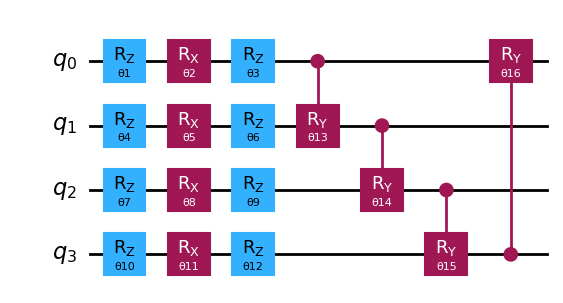

In [26]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import matplotlib.pyplot as plt

# Crear el circuito
qc = QuantumCircuit(4)

# Definir los valores de theta como parámetros de Qiskit
theta = [Parameter(f'θ{i}') for i in range(1, 17)]

# Agregar puertas con ángulos simbólicos
qc.rz(theta[0], 0)
qc.rx(theta[1], 0)
qc.rz(theta[2], 0)

qc.rz(theta[3], 1)
qc.rx(theta[4], 1)
qc.rz(theta[5], 1)

qc.rz(theta[6], 2)
qc.rx(theta[7], 2)
qc.rz(theta[8], 2)

qc.rz(theta[9], 3)
qc.rx(theta[10], 3)
qc.rz(theta[11], 3)

qc.cry(theta[12], 0, 1)
qc.cry(theta[13], 1, 2)
qc.cry(theta[14], 2, 3)
qc.cry(theta[15], 3, 0)

# Dibujar el circuito
qc.draw('mpl')
plt.show()

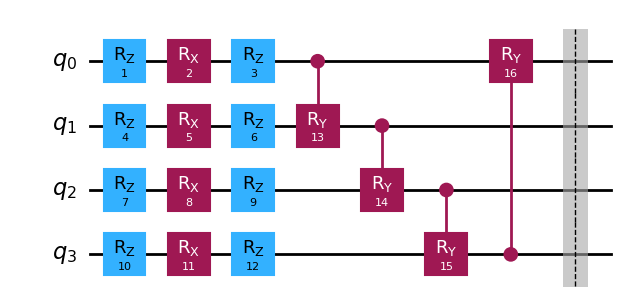

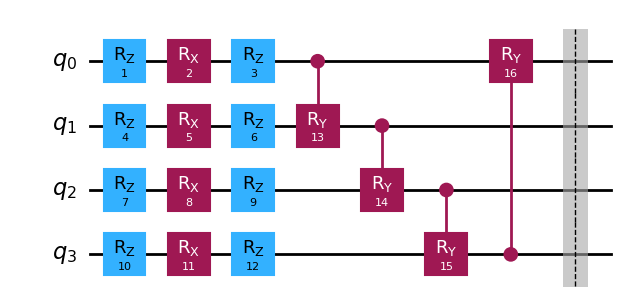

In [22]:
qc_combo.draw('mpl')

In [28]:
backendd = service.backend(name="ibm_kyoto")

In [8]:
def optimizar_depolarizacion(p_values):
    """
    Optimiza la depolarización para una lista de valores de p y devuelve un DataFrame con los resultados.

    :param p_values: Lista de valores de p para optimizar.
    :return: DataFrame con los valores de p, la fidelidad optimizada y los parámetros optimizados.
    """
    results = []
    
    backend = AerSimulator(method="density_matrix")

    for p in p_values:
        print("Trabajando con p =", p)
        target = choi_matrix_depolarizing(p)  # Genera la matriz objetivo para el valor de p
        
        def cost_func(params):
            '''
            Función de costo para hallar la matriz densidad objetivo. 
            
            Entradas:
                Globales: 
                    qubits: int
                        número de qubits a usar en el circuito. 
                    layers: int
                        número de capas a usar en el circuito. 
                    target: array, float
                        matriz densidad objetivo 
                Locales: 
                    params:float,array
                        parametros theta, correspondientes a las rotaciones a usar. 
            '''
            qc_combo = cirq_ansq(2, params, 1)[0]
            tomo_circuits = ProcessTomography(circuit=qc_combo, measurement_indices=[0], preparation_indices=[0])
            stdata = tomo_circuits.run(backend).block_for_results()
            choi_dens = stdata.analysis_results("state").value    
            # print(target)
            cost = -process_fidelity(target, choi_dens)  # Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
            print(cost*-1)
            return cost

        # Realiza la optimización
        opt_depolarizing = scipy.optimize.minimize(cost_func, np.random.rand(16) * 2 * np.pi, method='COBYLA', options={'maxiter': 1200, 'tol': 1e-15})
        
        # Almacena el resultado de esta iteración
        params = opt_depolarizing.x
        qc_combo = cirq_ansq(2, params, 1)[0]
        tomo_circuits = ProcessTomography(circuit=qc_combo, measurement_indices=[0], preparation_indices=[0])
        stdata = tomo_circuits.run(backend).block_for_results()
        choi_dens = stdata.analysis_results("state").value    
        prresultado_0 = process_fidelity(target, choi_dens)
        
        results.append({'p': p, 'x': params, 'choi_dens': choi_dens, 'Fidelidad': prresultado_0})
    
    # Convierte la lista de resultados en un DataFrame
    df_results = pd.DataFrame(results)
    
    # Opcional: expandir la columna 'x' en múltiples columnas para cada elemento de x
    x_df = pd.DataFrame(df_results['x'].tolist(), index=df_results.index)
    x_df.columns = [f'x{i}' for i in range(x_df.shape[1])]  # Nombrar las columnas como x0, x1, ...
    
    # Concatenar los DataFrames para tener una sola estructura de datos k
    df_results = pd.concat([df_results.drop(columns=['x']), x_df], axis=1)
    
    return df_results

# Ejemplo de uso
p_values = [0.125]
df_results_10 = optimizar_depolarizacion(p_values)


Trabajando con p = 0.125


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00040826  0.00040826]


0.1603222846821819
0.2034798511395935


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0162651  0.0162651]


0.207088702242568


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00087863  0.00087863]


0.2761593964032051


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00549191  0.00549191]


0.24080226186989886


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00505678  0.00505678]


0.23066871905697547


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00704586  0.00704586]


0.23677081598969119


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00458937  0.00458937]


0.22717215758690879


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0051517  0.0051517]


0.23302680524953623


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00412579  0.00412579]


0.2744778491917731


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00358294  0.00358294]


0.27476045525017667


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00199685  0.00199685]


0.23016115841513837
0.25010912898017346
0.2650239949844296


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0132808  0.0132808]


0.20925038181352554
0.24434253441151807


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00179764  0.00179764]


0.11854179815176641


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00151468  0.00151468]


0.4193315764991629


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00880083  0.00880083]


0.42471050420386


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00047895  0.00047895]


0.6261123233850305


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00139628  0.00139628]


0.6639633909106567


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00800776  0.00800776]


0.5868601781446832


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0018133  0.0018133]


0.9462481164661535
0.9136732541601092


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00551534  0.00551534]


0.9418234558446636
0.916885382662045
0.9819842377541537
0.9458623465180891


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01273264  0.01273264]


0.9318913686370273


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00701112  0.00701112]


0.8664801112443826


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00227485  0.00227485]


0.9433342871912958


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00421172  0.00421172]


0.9230408042090446


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00106215  0.00106215]


0.9483798447754366


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.02175551  0.02175551]


0.8821309647931755


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00118443  0.00118443]


0.9365775629732288


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00052137  0.00052137]


0.9439529353617069
0.7413524767548937


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00290334  0.00290334]


0.9516125123295266


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00743511  0.00743511]


0.9351923319681822


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00155433  0.00155433]


0.9431991466687897


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00724703  0.00724703]


0.9523975948853404


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00108579  0.00108579]


0.9281476807481864


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00042764  0.00042764]


0.9299888966097111
0.9599850152046713


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0020141  0.0020141]


0.9524068606914434
0.9718837185696677


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00327141  0.00327141]


0.9494436616340807
0.9762756641315312


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0090888  0.0090888]


0.9542328137215929


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00617235  0.00617235]


0.9623566605645575
0.9635679626364949
0.973042641996364


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0038021  0.0038021]


0.9536995130170149


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00155346  0.00155346]


0.950336745954913


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00269678  0.00269678]


0.9497017568645583


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00473601  0.00473601]


0.9483090307344813


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0031792  0.0031792]


0.9546915698211476
0.9635504524862266


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00316357  0.00316357]


0.953621025384774
0.9691783257530172


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00901285  0.00901285]


0.946914143390392
0.9653958151104851
0.9757933528411272


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0129443  0.0129443]


0.9505702743984304


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-4.1233333e-05  4.1233333e-05]


0.9554518680306784


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00127754  0.00127754]


0.9508857265168157
0.973554533209373


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01831635  0.01831635]


0.9193703267963028


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00384781  0.00384781]


0.9505374347720995


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00866546  0.00866546]


0.9395566521218301
0.9760419845537549


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00136695  0.00136695]


0.9498110305378507
0.9803384031158252


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00256519  0.00256519]


0.9497462636977092


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00913551  0.00913551]


0.9537259235221469


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00152768  0.00152768]


0.9497388759381011


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00079472  0.00079472]


0.9513343415515361


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00143189  0.00143189]


0.954367127200339


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0142647  0.0142647]


0.9445480623050826
0.9719191737448497
0.983889697731615
0.9757429077275703
0.973146101119337


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00750834  0.00750834]


0.9542112172038514
0.964742477179672


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00254419  0.00254419]


0.9457831639458982
0.9754448451134338
0.9753652277888812


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00097171  0.00097171]


0.9530341919597528


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00267776  0.00267776]


0.9504877017194837
0.9807462678428519


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00342145  0.00342145]


0.9517222280890427


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00062671  0.00062671]


0.9533602674894042


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00024676  0.00024676]


0.954607267979546


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00374455  0.00374455]


0.9524493343237501


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00413539  0.00413539]


0.9506697402035137


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00347034  0.00347034]


0.9482469557286408


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0001375  0.0001375]


0.9554231481342562


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00050005  0.00050005]


0.9528420592682392
0.9764433114391242


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00056791  0.00056791]


0.9534019344085094


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00045053  0.00045053]


0.9538803432196639


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00068208  0.00068208]


0.9481046391639512


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00637636  0.00637636]


0.9518320387321957


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00040384  0.00040384]


0.9481744094230476
0.9709664547876992


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00161158  0.00161158]


0.9509947814929719
0.9703711087081713


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00993103  0.00993103]


0.9376273156594329
0.9681785408281764


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00550584  0.00550584]


0.9526988883713285


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00481807  0.00481807]


0.9525564440286453


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00012733  0.00012733]


0.9511711714519933


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00604349  0.00604349]


0.9430674534952044


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00132713  0.00132713]


0.9544640025873032


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.002041  0.002041]


0.9509464358918702


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00074754  0.00074754]


0.9500677188469828


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00323792  0.00323792]


0.9546641311640446


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00353659  0.00353659]


0.9517239409411723


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00179184  0.00179184]


0.9514279974605981


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0001581  0.0001581]


0.9536433937617734
0.9543168246518727


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.003425  0.003425]


0.9447897374174979


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0056263  0.0056263]


0.9477222297513523


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-9.97314809e-05  9.97314809e-05]


0.9477955487931695


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00393012  0.00393012]


0.9520470770430192


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00051828  0.00051828]


0.9530568055532631


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0034771  0.0034771]


0.9528341746322868
0.9546221718778147


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00182527  0.00182527]


0.948991893032068


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00329068  0.00329068]


0.9494671214686259


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00241485  0.00241485]


0.9457026504104459
0.972203696581365
0.9707941728794821


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00254489  0.00254489]


0.9543593193915713
0.9786237810600801


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00022454  0.00022454]


0.9485932865583808
0.9710292629521479


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00597305  0.00597305]


0.9543323473182913
0.9656589586194521


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00089583  0.00089583]


0.951465743410905


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00061373  0.00061373]


0.9511510750414287


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00457293  0.00457293]


0.9468906951976516


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00386307  0.00386307]


0.9432229014650567


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00504908  0.00504908]


0.9520878180508264


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00112213  0.00112213]


0.9542759502941913
0.9718545744687536
0.9758824567219735


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00080129  0.00080129]


0.9512019259262264


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00739798  0.00739798]


0.9538691451149843


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00449606  0.00449606]


0.947391804417651


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-1.97951506e-05  1.97951506e-05]


0.9552662545919346
0.9710694277658931
0.9714440926561898


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00942274  0.00942274]


0.9520551447818735


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00321721  0.00321721]


0.9456447604679795


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00261931  0.00261931]


0.9482652987081471
0.9588898509647559


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00178169  0.00178169]


0.9457880540076171


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00444344  0.00444344]


0.950424520880178


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00257337  0.00257337]


0.9549250000646315


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01012035  0.01012035]


0.9479967843754707


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00090089  0.00090089]


0.9525745916237297


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00098255  0.00098255]


0.949029384017795
0.9651241260540054
0.9849289927793692


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00039315  0.00039315]


0.9505583612666849
0.9628706431685874
0.9757369426072758


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00133061  0.00133061]


0.9533286716486312


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00038096  0.00038096]


0.9508956106596621


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00167224  0.00167224]


0.9560949636661624


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0031317  0.0031317]


0.9511540479643519


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00202526  0.00202526]


0.9498073495029926


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0003432  0.0003432]


0.9500211993235811


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00163911  0.00163911]


0.9500327510890705


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00753752  0.00753752]


0.949673180589489


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00045021  0.00045021]


0.9527643036836121


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00186378  0.00186378]


0.9498436604031446


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00872562  0.00872562]


0.9421687924760943


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00080724  0.00080724]


0.9558280837555138


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00558609  0.00558609]


0.9524088154205188
0.9835547767892968


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0081382  0.0081382]


0.9484237922047672
0.9632327874126507
0.9702238041237161


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00743458  0.00743458]


0.9492857361658953


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01447974  0.01447974]


0.9422037694772811


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00232994  0.00232994]


0.9480178217654208
0.9807515565024075


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.005133  0.005133]


0.9509236819063716


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00372114  0.00372114]


0.9528229711756093


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0016777  0.0016777]


0.9499150994055784


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00173899  0.00173899]


0.9399151271396728
0.9538812548829358


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0092925  0.0092925]


0.9409202926814164


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00104854  0.00104854]


0.9553721764486441
0.9602777200589383


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00488995  0.00488995]


0.9519107963324582
0.9668099028193358


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01011763  0.01011763]


0.9526849099338953


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00091527  0.00091527]


0.9518040369681398


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00088978  0.00088978]


0.9516134670754713
0.9797693041679968


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00990206  0.00990206]


0.9452136964970795


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-3.18963762e-05  3.18963762e-05]


0.951486369486438
0.9666871633287459
0.9626594883092563


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00173169  0.00173169]


0.951008922806631
0.9751398642526838


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00262552  0.00262552]


0.9521076555162866


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00474243  0.00474243]


0.950329990318983
0.9740015680853061


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00376114  0.00376114]


0.9540730188203451
0.978566705745209


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00712955  0.00712955]


0.939499353290091
0.968515312410885


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00897326  0.00897326]


0.947569728825003


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00300588  0.00300588]


0.9464713718852176
0.9711397622951748
0.957165267357623


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00497829  0.00497829]


0.952644021851084
0.9629162553049186


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-2.20029126e-05  2.20029126e-05]


0.9550731166587878


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00092437  0.00092437]


0.9531645931009767


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.02139583  0.02139583]


0.9435847972242686


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00414742  0.00414742]


0.9505703006978677


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0042032  0.0042032]


0.9519320849682334


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00175841  0.00175841]


0.9536232484095767


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00250347  0.00250347]


0.9519466358875399
0.9584548468578384


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00398327  0.00398327]


0.9448192309770931


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00174514  0.00174514]


0.9512780581715458


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0035778  0.0035778]


0.9509798663965459
0.9663601527560493
0.9569379174435304


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0017063  0.0017063]


0.9478816723678629


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00048628  0.00048628]


0.9538974883143404


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00397758  0.00397758]


0.9473618131309535
0.9575167636416055


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01296825  0.01296825]


0.9478606712477348


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00238893  0.00238893]


0.9506256858778659
0.9732988890777283
0.9792998458501495


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01160201  0.01160201]


0.9513692120601005
0.9788290227971115


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00708797  0.00708797]


0.9422576576559754
0.9735864884841813


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0074466  0.0074466]


0.950569160159583


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00515861  0.00515861]


0.9498602028987514


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00526886  0.00526886]


0.9497997908165914
0.9695097794414326


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00825754  0.00825754]


0.9494741853297014


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00206813  0.00206813]


0.9480641155319255


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00051168  0.00051168]


0.9456381188453199


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00512912  0.00512912]


0.9479146226289923


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00293955  0.00293955]


0.9540141475604309


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0035598  0.0035598]


0.9476090322580533
0.9550435245367894


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00815851  0.00815851]


0.9413584317083625


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00086096  0.00086096]


0.9474380003826283
0.9752767168555813


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01267045  0.01267045]


0.949918120723074
0.9664779777613117


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00597317  0.00597317]


0.9473838584853168


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00041575  0.00041575]


0.9438188976421038
0.9577899121415675
0.9811969582400141


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01287765  0.01287765]


0.954066611233732


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00495769  0.00495769]


0.9494551830869807
0.9608454924657865


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00880506  0.00880506]


0.9399234714831539


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0072292  0.0072292]


0.9484642531257991


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00066321  0.00066321]


0.9506285744214048


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00647688  0.00647688]


0.9477012991984163


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00925771  0.00925771]


0.9480058687585343


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01025721  0.01025721]


0.9474968335560685
0.9773692666690673


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00705951  0.00705951]


0.9458205561042218
0.9675767565811794
0.9779281450182159


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00323394  0.00323394]


0.9511371569019346


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0058144  0.0058144]


0.9526428246934114


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.005077  0.005077]


0.9502797783971335


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00265943  0.00265943]


0.953181329508447


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00085215  0.00085215]


0.9473721928948431
0.9646916092888921


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00127329  0.00127329]


0.9521255924296015


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0008194  0.0008194]


0.9436948763699438


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00531243  0.00531243]


0.9498863535704641


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00387542  0.00387542]


0.952949611782412


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00344378  0.00344378]


0.9582072648481554


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00115522  0.00115522]


0.9506030840695768


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01572705  0.01572705]


0.9440273985334072


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00414387  0.00414387]


0.943817610191138


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00144337  0.00144337]


0.9489859111045493
0.9804053237707179


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00226294  0.00226294]


0.9505353200595658


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00553808  0.00553808]


0.9498385274603444


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00326515  0.00326515]


0.9396222073966072


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00626721  0.00626721]


0.953755138093634


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00529426  0.00529426]


0.9501753187540047


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00201059  0.00201059]


0.94912211260448


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00165292  0.00165292]


0.9521122446594942
0.9603908112284646


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00420282  0.00420282]


0.9547020221448764
0.9805821757552539
0.9718020269923942
0.9539784752535169
0.9738404985342067


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00261405  0.00261405]


0.9520394346723673


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00327267  0.00327267]


0.9529824380799481


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00730352  0.00730352]


0.9500690155033239


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00177992  0.00177992]


0.9481655968091626


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00352161  0.00352161]


0.9461551517832069
0.9625461248694618
0.9561346951042827
0.9660412581586508


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00626822  0.00626822]


0.9469529051392871


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01518823  0.01518823]


0.948515716230217


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.02312652  0.02312652]


0.9333439254642001


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00088066  0.00088066]


0.9513101924930719


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0033824  0.0033824]


0.9530380383679644
0.9549968042058204
0.969685611257617
0.9676800135820555
0.9591957358498914


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00556922  0.00556922]


0.9455349193319993


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0004969  0.0004969]


0.9542313103536901


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00689015  0.00689015]


0.9481368687594949


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01191437  0.01191437]


0.9451617447016789
0.9589166768362767


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00171566  0.00171566]


0.9536125433842926


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00201916  0.00201916]


0.9495111005672614
0.9655538242703231


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00225294  0.00225294]


0.9479873117502218


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00040224  0.00040224]


0.9524174505453108


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00667934  0.00667934]


0.9429068805806398
0.9630421635805957


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00528115  0.00528115]


0.9420825140420227


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00579534  0.00579534]


0.9522367953417411


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00087749  0.00087749]


0.954695860975163
0.9745174201177724


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00131303  0.00131303]


0.9566507871202355
0.9652310052605947


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00032769  0.00032769]


0.952807124695071


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00278435  0.00278435]


0.9499217442127696


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00370574  0.00370574]


0.9545169779470668


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00372987  0.00372987]


0.9478980508875001


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00466751  0.00466751]


0.9506263784066636


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00173798  0.00173798]


0.9491299328506826


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01391315  0.01391315]


0.930110836678713


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0058665  0.0058665]


0.9527140117152781


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0059794  0.0059794]


0.9481553221583483


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00249146  0.00249146]


0.9552480246752126


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00222179  0.00222179]


0.9541983225085193


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00304889  0.00304889]


0.9444230572323776


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00083552  0.00083552]


0.9509271825978574
0.9668917710548216
0.9754606277805119


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01219044  0.01219044]


0.9470254195724779
0.9665101884166153
0.9644546438860017
0.9732433243539551


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00626408  0.00626408]


0.9484605253240104
0.9716672113956848


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-1.70240583e-05  1.70240583e-05]


0.9500264990473102
0.9726022567011146


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00195238  0.00195238]


0.9508717010922039


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01510905  0.01510905]


0.9473764657992892


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00780725  0.00780725]


0.9545070482940633


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0005034  0.0005034]


0.9524688870409748
0.9796123007546982


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00133181  0.00133181]


0.9459858521557191


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00441522  0.00441522]


0.9501664516454194


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00405978  0.00405978]


0.9524536502147012
0.9660090372881209


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00628205  0.00628205]


0.9519856882530471


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00728123  0.00728123]


0.9500799563317072
0.9755392701934453
0.9756923028445997
0.9514237767734364
0.9781530923534587


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00188412  0.00188412]


0.9506620247207151
0.9793042422441293


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00245088  0.00245088]


0.9505633724400281


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.000239  0.000239]


0.9529478106346598


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00348188  0.00348188]


0.947379374070245


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00205726  0.00205726]


0.9526155894279633
0.9463171413545813


KeyboardInterrupt: 

In [77]:
def optimizar_depolarizacion(p_values):
    """
    Optimiza la depolarización para una lista de valores de p y devuelve un DataFrame con los resultados.

    :param p_values: Lista de valores de p para optimizar.
    :return: DataFrame con los valores de p, la fidelidad optimizada y los parámetros optimizados.
    """
    results = []
    
    backend = AerSimulator()

    for p in p_values:
        print("Trabajando con p =", p)
        target = choi_matrix_depolarizing(p)  # Genera la matriz objetivo para el valor de p
        
        # Realiza la optimización
        # print(target)
        opt_depolarizing = scipy.optimize.minimize(cost_func, np.random.rand(8)*2*np.pi, method='COBYLA', options={'maxiter':1000, 'tol':0.00000000001})
        
        # Almacena el resultado de esta iteración
        params = opt_depolarizing.x
        # print(target)
        # Crear el circuito cuántico y realizar la tomografía de procesos
        # qc = QuantumCircuit(2)
        # qc.h(0)
        # qc.cx(0, 1)
        # qc.barrier(0,1,2,3)
        
        # qc_combo = qc.compose(cirq_ansq(2, params, 1)[0])
        qc_combo = cirq_ansq(1, params, 1)[0]
        
        tomo_circuits = ProcessTomography(circuit=qc_combo, measurement_indices=[0], preparation_indices=[0])
        stdata = tomo_circuits.run(backend).block_for_results()
        choi_dens = stdata.analysis_results("state").value    
        
        prresultado_0 = process_fidelity(target, choi_dens)
        
        results.append({'p': p, 'x': params, 'choi_dens': choi_dens, 'Fidelidad': prresultado_0})
    
    # Convierte la lista de resultados en un DataFrame
    df_results = pd.DataFrame(results)
    
    # Opcional: expandir la columna 'x' en múltiples columnas para cada elemento de x
    x_df = pd.DataFrame(df_results['x'].tolist(), index=df_results.index)
    x_df.columns = [f'x{i}' for i in range(x_df.shape[1])]  # Nombrar las columnas como x0, x1, ...
    
    # Concatenar los DataFrames para tener una sola estructura de datos
    df_results = pd.concat([df_results.drop(columns=['x']), x_df], axis=1)
    
    return df_results

def cost_func(params):
    '''
    Función de costo para hallar la matriz densidad objetivo. 
    
    Entradas:
        Globales: 
            qubits: int
                número de qubits a usar en el circuito. 
            layers: int
                número de capas a usar en el circuito. 
            target: array, float
                matriz densidad objetivo 
        Locales: 
            params:float,array
                parametros theta, correspondientes a las rotaciones a usar. 
    
    '''
    
    
    # Dens= cirq_ansq(2,params,1)[1] #Genera un dummy circuit
    # qc=QuantumCircuit(2)
    # qc.h(0)
    # qc.cx(0, 1)
    # qc.barrier(0,1,2,3)
    qc_combo = (cirq_ansq(1,params,1)[0])
    # qc_combo = qc.compose(cirq_ansq(2,params,1)[0])
    # qc_combined = cirq_ansq(1,params,1)[0]
    # depola(1)
    backend = AerSimulator()
    tomo_circuits = ProcessTomography(circuit=qc_combo,
                                measurement_indices=[0],
                                 preparation_indices=[0],
                                     )
    stdata = tomo_circuits.run(backend).block_for_results()
    choi_dens = stdata.analysis_results("state").value    
    print(target)
    cost=-process_fidelity(target,choi_dens)  #Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
    print(process_fidelity(target,choi_dens))
    costo.append(cost*-1)
    return cost




Trabajando con p = 0.125


Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01240032  0.01240032]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.01240032  0.01240032]


Choi([[0.575+0.j, 0.   +0.j, 0.   +0.j, 0.15 +0.j],
      [0.   +0.j, 0.425+0.j, 0.   +0.j, 0.   +0.j],
      [0.   +0.j, 0.   +0.j, 0.425+0.j, 0.   +0.j],
      [0.15 +0.j, 0.   +0.j, 0.   +0.j, 0.575+0.j]],
     input_dims=(2,), output_dims=(2,))
0.3235490237357456


NameError: name 'costo' is not defined

In [5]:
p=0.85
target = choi_matrix_depolarizing(p)
i = df_results_6[df_results_6.p==p].index[0]
qc_combo = cirq_ansq(2,
                                [df_results_6.x0[i],
                                df_results_6.x1[i],
                                df_results_6.x2[i],
                                df_results_6.x3[i],
                                df_results_6.x4[i],
                                df_results_6.x5[i],
                                df_results_6.x6[i],
                                df_results_6.x7[i],           
                                df_results_6.x8[i],  
                                df_results_6.x9[i],  
                                df_results_6.x10[i],  
                                df_results_6.x11[i],  
                                df_results_6.x12[i],  
                                df_results_6.x13[i],          
                                df_results_6.x14[i],    
                                df_results_6.x15[i]],              
                                1)[0]
backend = AerSimulator()
tomo_circuits = ProcessTomography(circuit=qc_combo,
                                measurement_indices=[0],
                                 preparation_indices=[0],
                                     )
stdata = tomo_circuits.run(backend).block_for_results()
choi_dens = stdata.analysis_results("state").value    

prresultado_0 = process_fidelity(target,choi_dens)  #Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
prresultado_0

NameError: name 'df_results_6' is not defined

In [41]:
p_values=[0.01]
# costo=[]
target=choi_matrix_depolarizing(0.01)
df_results_5 = optimizar_depolarizacion(p_values)

In [9]:
def depolarizing(p):
    #Se usa la rotación theta como la parametrización de p 
    theta =  1/2 * np.arccos(1-2*p)
    
    #Implementación del circuit 
    cuantar=QuantumCircuit(4)
    cuantar.ry(theta,0)
    cuantar.ry(theta,2)
    cuantar.ry(theta,3)
    cuantar.cx(0,1)
    cuantar.cy(2,1)
    cuantar.cz(3,1)
    return cuantar

In [177]:
target = choi_matrix_depolarizing(0.69)
# qc = QuantumCircuit(4)
# qc.h(0)
# qc.cx(0, 1)
# qc.barrier(0,1,2,3)
# # qc = (cirq_ansq(2,params,1)[0])
# qc_combo = qc.compose(depolarizing(0.48))

# backend = AerSimulator()
tomo_circuits = ProcessTomography(circuit=depolarizing(0.69),
                                measurement_indices=[1],
                                 preparation_indices=[1],target=target
                                     )
backend=AerSimulator()
stdata = tomo_circuits.run(backend).block_for_results()
choi_dens =  stdata.analysis_results("state").value    

prresultado_0 = process_fidelity(target,choi_dens)  #Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
prresultado_0
       

0.9971550146909101

In [ ]:

# Choi(depolarizing_error(0.2, 1))
# choi_matrix_depolarizing(0.1)

## Ejecución en Computadoras Cuánticas

In [133]:
df_final = pd.read_pickle("df_depolarizing_finalizado_01-06-2024")

In [135]:
df_final = df_final.rename(columns={"Choi_sim":"Choi_sim_1"})

In [158]:
service = QiskitRuntimeService()

In [159]:
backend = service.backend(name="ibm_kyoto")
# backend=AerSimulator()

In [140]:
"""
Código para ejecutar en batch y añadir datos iterativamente al dataframe, usar únicamente si no hay retraso en ejecución en la computadora cuántica. 

"""
# Lista de valores de p
p_values = list(df_final.p)  # Añade todos los valores de p que quieras iterar

# Backend
backend = AerSimulator()

# Iterar sobre cada valor de p
for p in p_values:
    target = choi_matrix_depolarizing(p)
    i = df_final[df_final.p == p].index[0]
    
    qc_combo = cirq_ansq(
        2,
        [
            df_final.x0[i],
            df_final.x1[i],
            df_final.x2[i],
            df_final.x3[i],
            df_final.x4[i],
            df_final.x5[i],
            df_final.x6[i],
            df_final.x7[i],
            df_final.x8[i],
            df_final.x9[i],
            df_final.x10[i],
            df_final.x11[i],
            df_final.x12[i],
            df_final.x13[i],
            df_final.x14[i],
            df_final.x15[i],
        ],
        1
    )[0]
    
    tomo_circuits = ProcessTomography(
        circuit=qc_combo,
        measurement_indices=[0],
        preparation_indices=[0],
    )
    
    stdata = tomo_circuits.run(backend).block_for_results()
    choi_dens = stdata.analysis_results("state").value
    prresultado_0 = process_fidelity(target, choi_dens)
    
    a = pd.DataFrame({'p': [p], 'Fidelidad_sim': prresultado_0, 'Choi_sim': choi_dens})
    
    # Asegurarse de que los DataFrames tienen un índice alineado
    df_final.set_index('p', inplace=True)
    a.set_index('p', inplace=True)
    
    # Concatenar los DataFrames en las columnas deseadas
    df_final = df_final.combine_first(a)
    df_final = df_final.reset_index()

# Guardar los resultados finales
# df_final.to_pickle("resultados1-1-06-24")

Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00994124  0.00994124]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00604559  0.00604559]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00051066  0.00051066]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0074791  0.0074791]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00726586  0.00726586]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.00603472  0.00603472]
Target channel is not TP. Tr_2[Choi] - I has non-zero eigenvalues: [-0.0053191  0.0053191]


In [57]:
"""
Código para ejecución individual . Usar cuando haya retraso en la qc
"""
p=0.225
target = choi_matrix_depolarizing(p)
i = df_final[df_final.p==p].index[0]
qc_combo = cirq_ansq(2,
                                [df_final.x0[i],
                                df_final.x1[i],
                                df_final.x2[i],
                                df_final.x3[i],
                                df_final.x4[i],
                                df_final.x5[i],
                                df_final.x6[i],
                                df_final.x7[i],           
                                df_final.x8[i],  
                                df_final.x9[i],  
                                df_final.x10[i],  
                                df_final.x11[i],  
                                df_final.x12[i],  
                                df_final.x13[i],          
                                df_final.x14[i],    
                                df_final.x15[i]],              
                                1)[0]
# backend = backend
backend=AerSimulator()
tomo_circuits = ProcessTomography(circuit=qc_combo,
                                measurement_indices=[0],
                                 preparation_indices=[0],
                                     )
stdata = tomo_circuits.run(backend).block_for_results()
choi_dens = stdata.analysis_results("state").value    

prresultado_0 = process_fidelity(target,choi_dens)  #Se compara la fidelidad y luego se obtiene el negativo para ser minimizado. 
prresultado_0

0.9717802758194684

In [36]:
a = pd.DataFrame({'p': [p], 'Fidelidad_qc': prresultado_0 , 
 'Choi_qc':choi_dens,'QC':qc_combo,'Choi_obj': target })

In [59]:
# Asegurarse de que los DataFrames tienen un índice alineado
df_final.set_index('p', inplace=True)
a.set_index('p', inplace=True)

# Concatenar los DataFrames en las columnas deseadas
df_final2 = df_final.combine_first(a)
df_final2 = df_final2.reset_index()

df_final2.to_pickle("resultados1-1-06-24")
df_final = df_final2

## Visualización de Resultados para Depolarizing Channel

Se hizo la primera iteración usando VQA para iniciar el canal de depolarización sobre un qubit. Para esto se generaba la matriz de choi del canal para cada p. Posteriomrente se optimizó la función de costo usando el simulador y finalmente con la mejor fidelidad se obtuvo la matriz de choi en el simulador. Posteriormente se ejecutó en la computadora cuántica "ibm-kyoto"

In [10]:
# !pip install qiskit==1.0

In [5]:
df_depo = pd.read_pickle("resultados_tratados_15-08-24")

### Cálculo de medias, trazas parciales y desviaciones

In [20]:
# # Aplicar la función partial_trace a cada matriz de Choi en tu DataFrame y guardar el resultado en nuevas columnas
# df_depo['Choi_obj_traza'] = df_depo['Choi_obj'].apply(lambda x: partial_trace(np.real(x)))
# df_depo['Choi_qc_traza'] = df_depo['Choi_qc'].apply(lambda x: partial_trace(np.real(x)))
# df_depo['Choi_sim_1_traza'] = df_depo['Choi_sim_1'].apply(lambda x: partial_trace(np.real(x)))
# df_depo['Choi_sim_2_traza'] = df_depo['Choi_sim_2'].apply(lambda x: partial_trace(np.real(x)))
# df_depo['Choi_sim_3_traza'] = df_depo['Choi_sim_3'].apply(lambda x: partial_trace(np.real(x)))
# df_depo['Choi_sim_4_traza'] = df_depo['Choi_sim_4'].apply(lambda x: partial_trace(np.real(x)))


# # """
# # Cálculo de RMSE Y MAE para fidelidades en QC .
# # """
# # Crear columna de promedio de fidelidad
# df_depo['Fidelidad_prom'] = df_depo[['Fidelidad_sim_1', 'Fidelidad_sim_2', 'Fidelidad_sim_3', 'Fidelidad_sim_4']].mean(axis=1)

# # Calcular MAE
# df_depo['MAE'] = (
#     abs(df_depo['Fidelidad_sim_1'] - df_depo['Fidelidad_prom']) +
#     abs(df_depo['Fidelidad_sim_2'] - df_depo['Fidelidad_prom']) +
#     abs(df_depo['Fidelidad_sim_3'] - df_depo['Fidelidad_prom']) +
#     abs(df_depo['Fidelidad_sim_4'] - df_depo['Fidelidad_prom'])
# ) / 4

# # Calcular RMSE
# df_depo['RMSE'] = (
#     (
#         (df_depo['Fidelidad_sim_1'] - df_depo['Fidelidad_prom']) ** 2 +
#         (df_depo['Fidelidad_sim_2'] - df_depo['Fidelidad_prom']) ** 2 +
#         (df_depo['Fidelidad_sim_3'] - df_depo['Fidelidad_prom']) ** 2 +
#         (df_depo['Fidelidad_sim_4'] - df_depo['Fidelidad_prom']) ** 2
#     ) / 4
# ) ** 0.5

#Calcular el error para simualciones usando std
# df_depo['std_error'] = df_depo[['Fidelidad_sim_1', 'Fidelidad_sim_2', 'Fidelidad_sim_3', 'Fidelidad_sim_4']].std(axis=1)

# # # Guardar los resultados finales
# df_depo.to_pickle("resultados_tratados_15-08-24")

### Visualización de estadísticos globales

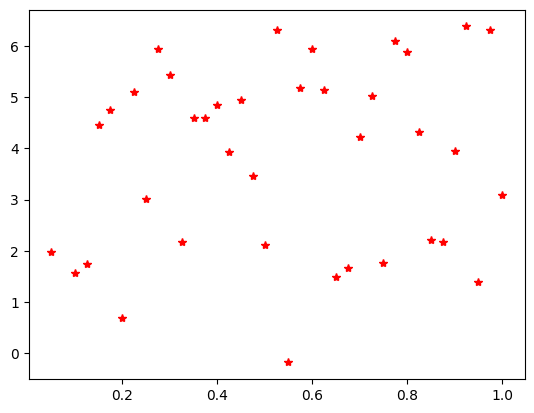

In [59]:
plt.plot(df_depo["p"],df_depo["x0"],"r*")

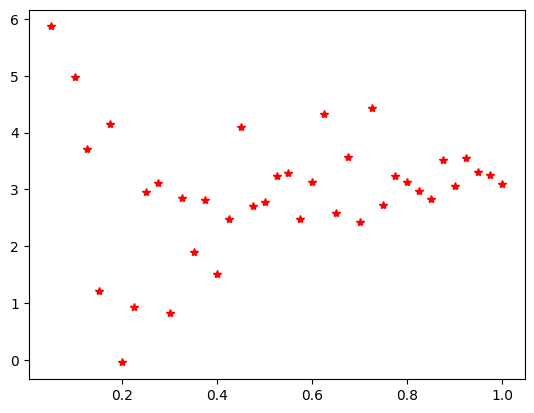

In [89]:
plt.plot(df_depo["p"],df_depo["x15"],"r*")

<>:29: SyntaxWarning: invalid escape sequence '\c'
<>:29: SyntaxWarning: invalid escape sequence '\c'
C:\Users\felip\AppData\Local\Temp\ipykernel_18304\2968675816.py:29: SyntaxWarning: invalid escape sequence '\c'
  plt.plot(df_depo['p'], y_pred, label='Regresión Lineal \n' + f"{equation}\n$R^2$ = {r_squared:.4f}\n$\chi^2$ = {chi_squared:.4f}", color='black')


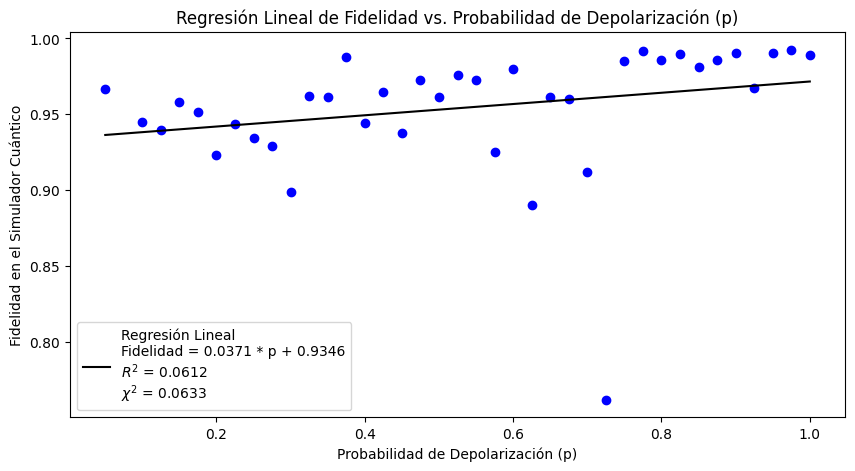

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Supongamos que df_depo es tu DataFrame con las columnas 'p' y 'Fidelidad_prom'
X = df_depo['p'].values.reshape(-1, 1)  # Probabilidad de depolarización p
y = df_depo['Fidelidad_prom'].values  # Fidelidad en la computadora cuántica

# Crear el modelo de regresión lineal
modelo = LinearRegression()

# Ajustar el modelo a los datos
modelo.fit(X, y)

# Predecir los valores de fidelidad para los valores de p
y_pred = modelo.predict(X)

# Calcular R^2 y Chi^2
r_squared = r2_score(y, y_pred)
chi_squared = np.sum(((y - y_pred) ** 2) / y_pred)

# Ecuación de la recta
slope = modelo.coef_[0]
intercept = modelo.intercept_
equation = f"Fidelidad = {slope:.4f} * p + {intercept:.4f}"

# Plotear los datos originales y la línea de regresión
plt.figure(figsize=(10, 5))
plt.plot(df_depo['p'], df_depo['Fidelidad_prom'], 'o',color='blue')
plt.plot(df_depo['p'], y_pred, label='Regresión Lineal \n' + f"{equation}\n$R^2$ = {r_squared:.4f}\n$\chi^2$ = {chi_squared:.4f}", color='black')

# Configuración del gráfico
plt.xlabel('Probabilidad de Depolarización (p)')
plt.ylabel('Fidelidad en el Simulador Cuántico')
plt.title('Regresión Lineal de Fidelidad vs. Probabilidad de Depolarización (p)')
plt.legend(loc="best")
plt.show()


C:\Users\felip\AppData\Local\Temp\ipykernel_18304\2824819017.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_per_bin = df_depo.groupby('p_bins')['Fidelidad_qc'].mean()


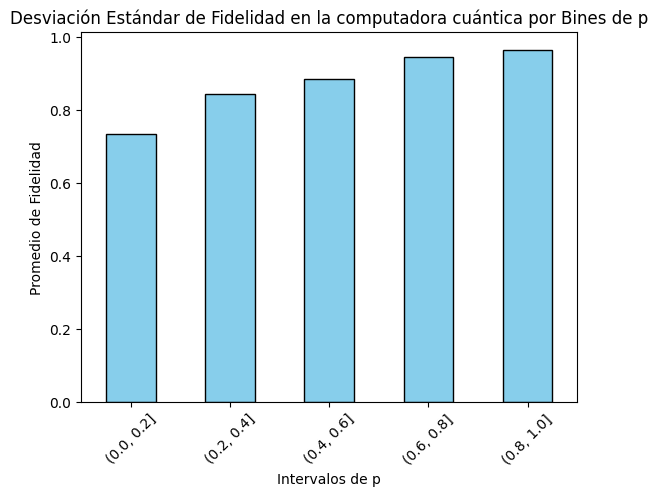

In [44]:
# Definir los límites de los bines
bins = [0, 0.20,0.40, 0.60, 0.80, 1]

# Crear los bines usando pd.cut
df_depo['p_bins'] = pd.cut(df_depo['p'], bins=bins)

# Agrupar por los bines y calcular la desviación estándar de Fidelidad_qc en cada bin
std_per_bin = df_depo.groupby('p_bins')['Fidelidad_qc'].mean()

# Plotear la desviación estándar por bines
std_per_bin.plot(kind='bar', color='skyblue', edgecolor='black')

# Agregar títulos y etiquetas
plt.title('Desviación Estándar de Fidelidad en la computadora cuántica por Bines de p')
plt.xlabel('Intervalos de p')
plt.ylabel('Promedio de Fidelidad')
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

C:\Users\felip\AppData\Local\Temp\ipykernel_18304\1525094175.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_per_bin = df_depo.groupby('p_bins')['Fidelidad_prom'].mean()


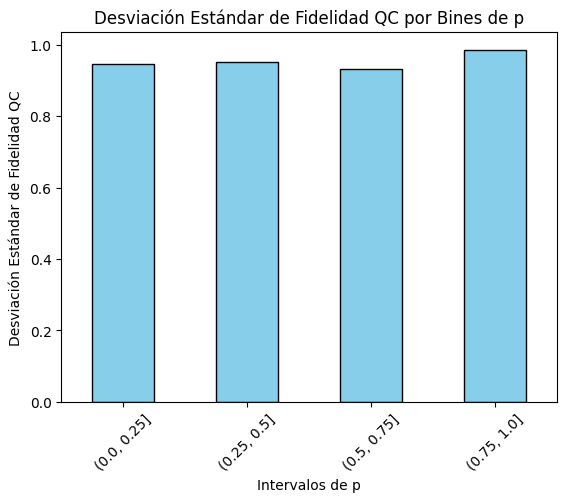

In [42]:
# Definir los límites de los bines
bins = [0, 0.25, 0.50, 0.75,1.0]

# Crear los bines usando pd.cut
df_depo['p_bins'] = pd.cut(df_depo['p'], bins=bins)

# Agrupar por los bines y calcular la desviación estándar de Fidelidad_qc en cada bin
std_per_bin = df_depo.groupby('p_bins')['Fidelidad_prom'].mean()

# Plotear la desviación estándar por bines
std_per_bin.plot(kind='bar', color='skyblue', edgecolor='black')

# Agregar títulos y etiquetas
plt.title('Desviación Estándar de Fidelidad QC por Bines de p')
plt.xlabel('Intervalos de p')
plt.ylabel('Desviación Estándar de Fidelidad QC')
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

In [32]:
df_depo[df_depo.p>=0.6].Fidelidad_qc.std()

0.024471407141338664

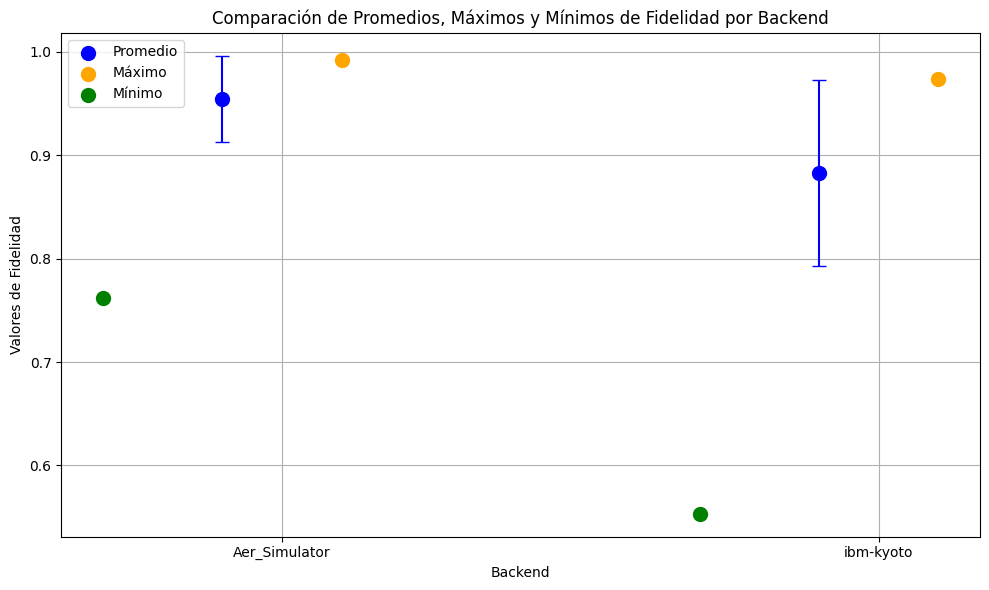

In [9]:
# Datos extraídos de la imagen proporcionada
labels = ['Aer_Simulator', 'ibm-kyoto']
promedios = [0.9545, 0.8829]
maximos = [0.9925, 0.9738]
minimos = [0.762, 0.5533]
desviaciones_estandar = [0.0418, 0.0899]

# Configuración del gráfico con puntos más cercanos
x = np.arange(len(labels))  # Posición en el eje x
x_shifted = x - 0.1  # Ajuste para acercar los puntos

fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de puntos para los promedios
ax.scatter(x_shifted, promedios, label='Promedio', color='blue', s=100)
ax.errorbar(x_shifted, promedios, yerr=desviaciones_estandar, fmt='o', color='blue', capsize=5)

# Gráfico de puntos para los máximos
ax.scatter(x_shifted + 0.2, maximos, label='Máximo', color='orange', s=100)

# Gráfico de puntos para los mínimos
ax.scatter(x_shifted - 0.2, minimos, label='Mínimo', color='green', s=100)

# Añadir etiquetas y título
ax.set_xlabel('Backend')
ax.set_ylabel('Valores de Fidelidad')
ax.set_title('Comparación de Promedios, Máximos y Mínimos de Fidelidad por Backend')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Activar la cuadrícula
ax.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

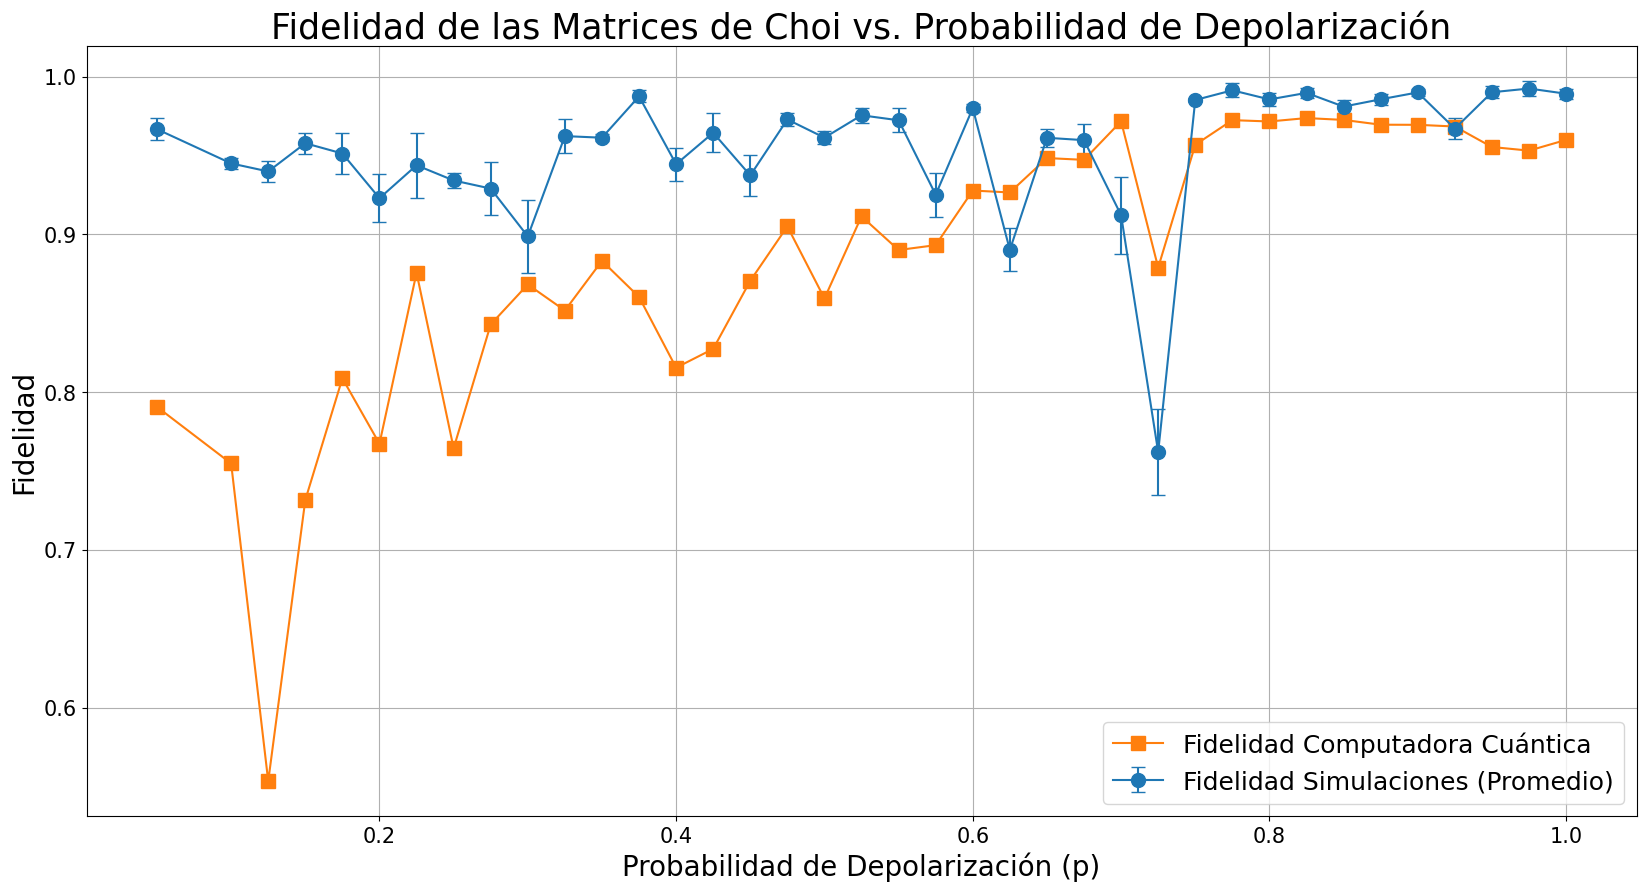

In [21]:
plt.figure(figsize=(20,10))

plt.errorbar(df_depo['p'], df_depo['Fidelidad_prom'], yerr=df_depo['std_error'], fmt='-o', label='Fidelidad Simulaciones (Promedio)', capsize=5, markersize=10)
plt.plot(df_depo['p'], df_depo['Fidelidad_qc'], '-s', label='Fidelidad Computadora Cuántica', markersize=10)

plt.title('Fidelidad de las Matrices de Choi vs. Probabilidad de Depolarización', fontsize=25)
plt.xlabel('Probabilidad de Depolarización (p)', fontsize=20)
plt.ylabel('Fidelidad', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)  # Aumenta el tamaño de los ticks
plt.legend(fontsize=18)  # Aumenta el tamaño de la leyenda
plt.grid(True)
plt.show()

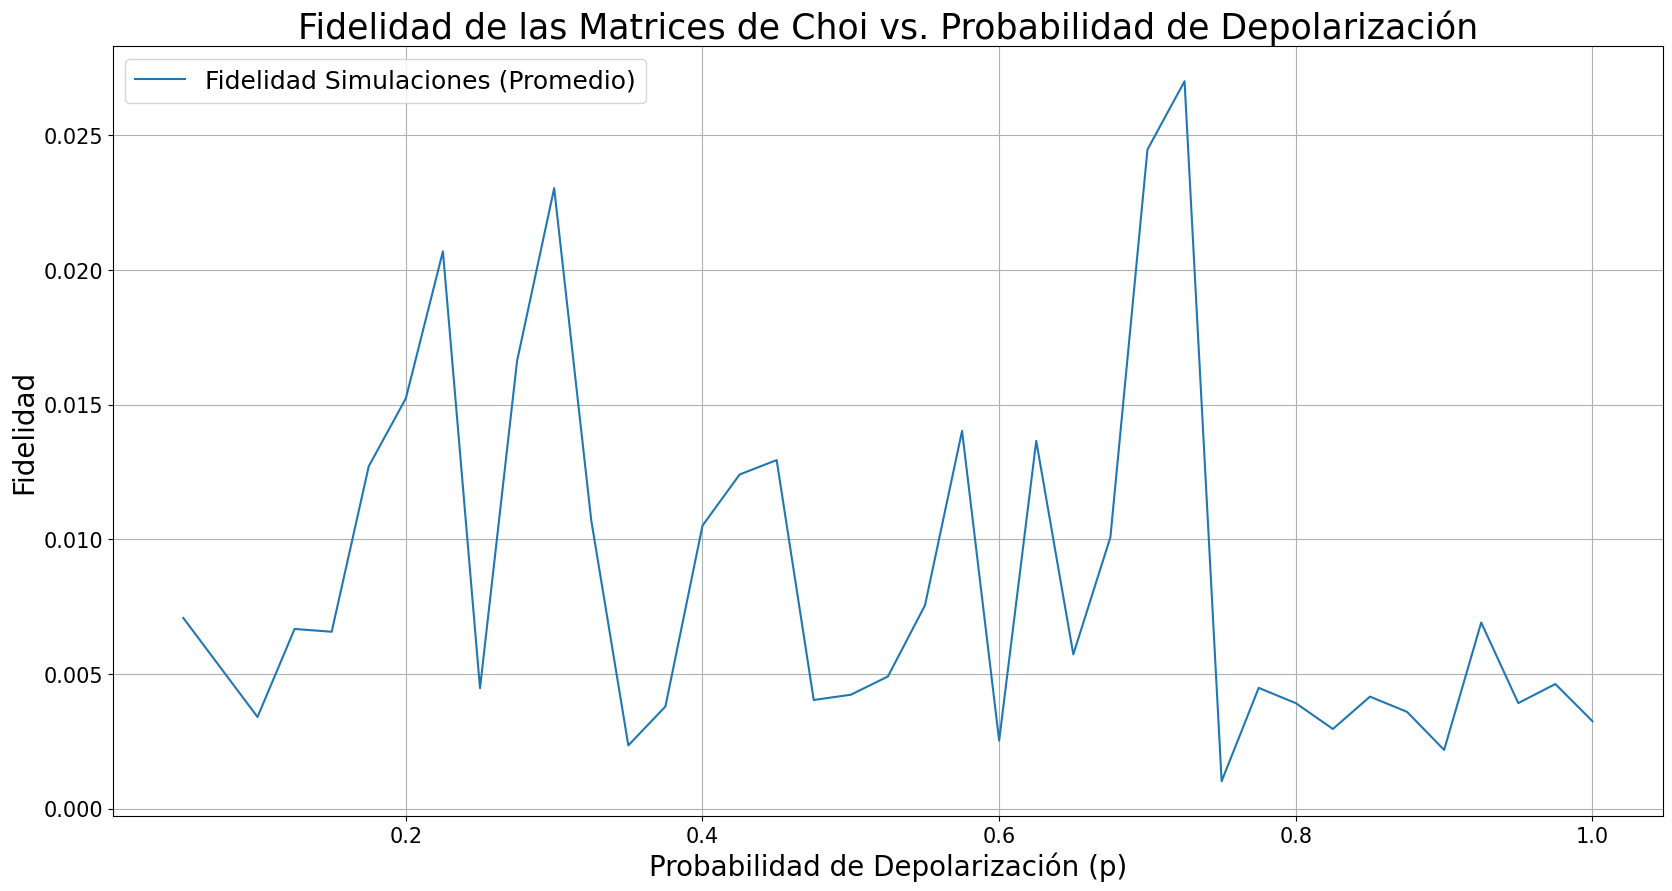

In [24]:
plt.figure(figsize=(20,10))

plt.plot(df_depo['p'], df_depo['std_error'], label='Fidelidad Simulaciones (Promedio)', markersize=10)
# plt.plot(df_depo['p'], df_depo['Fidelidad_qc'], '-s', label='Fidelidad Computadora Cuántica', markersize=10)

plt.title('Fidelidad de las Matrices de Choi vs. Probabilidad de Depolarización', fontsize=25)
plt.xlabel('Probabilidad de Depolarización (p)', fontsize=20)
plt.ylabel('Fidelidad', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)  # Aumenta el tamaño de los ticks
plt.legend(fontsize=18)  # Aumenta el tamaño de la leyenda
plt.grid(True)
plt.show()

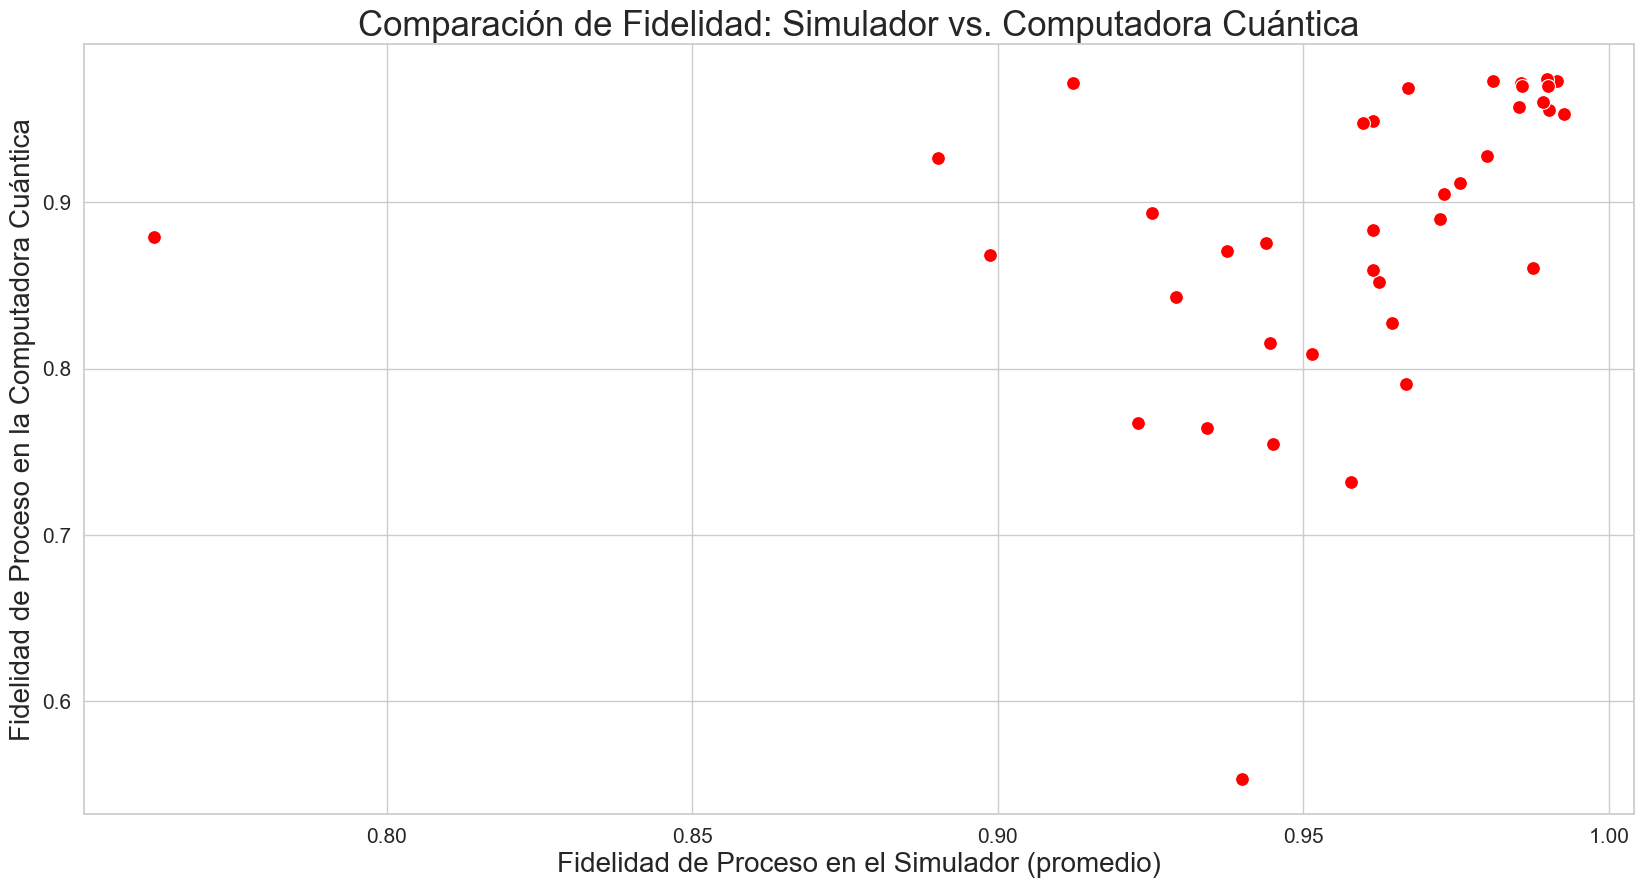

In [29]:
# Configuración del estilo visual de Seaborn
sns.set(style="whitegrid")

# Creación del gráfico de dispersión con Seaborn
plt.figure(figsize=(20,10))
sns.scatterplot(x='Fidelidad_prom', y='Fidelidad_qc', data=df_depo, color='red', s=100)  # Ajusta el tamaño de los puntos con 's'

# Añadiendo detalles al gráfico
plt.title('Comparación de Fidelidad: Simulador vs. Computadora Cuántica', fontsize=25)
plt.xlabel('Fidelidad de Proceso en el Simulador (promedio)', fontsize=20)
plt.ylabel('Fidelidad de Proceso en la Computadora Cuántica', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)  # Aumenta el tamaño de los ticks
plt.grid(True)

# Mostrar el gráfico
plt.show()

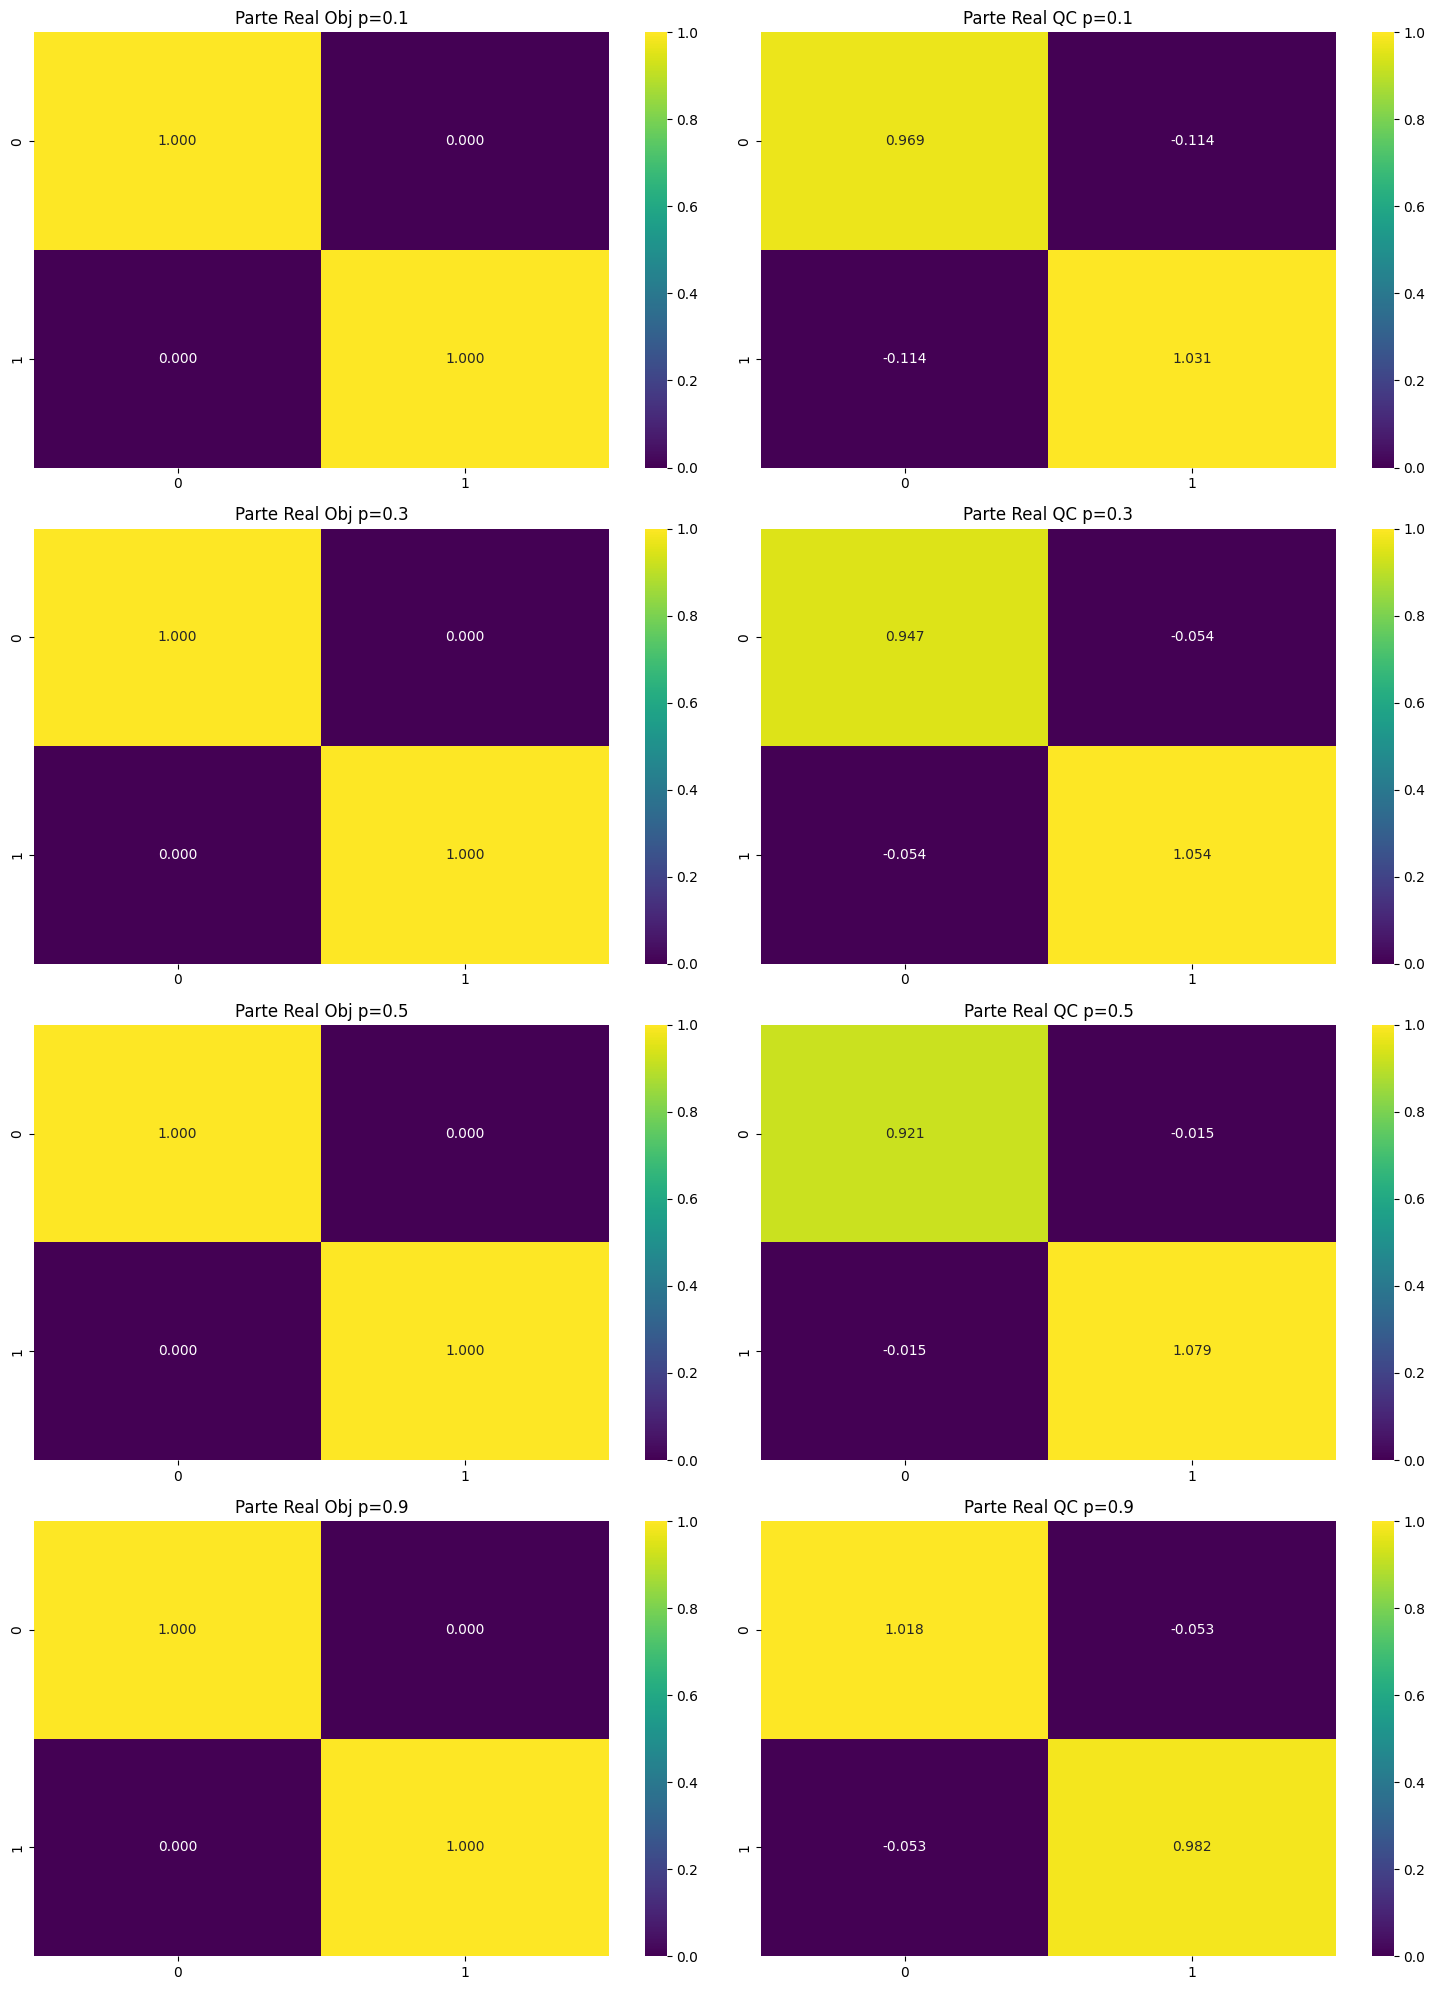

In [90]:
# Definimos los valores de p a graficar
p_values_to_plot = [0.1, 0.3, 0.5, 0.9]
filtered_rows = df_depo[df_depo['p'].isin(p_values_to_plot)]

# Configuración de la figura
num_p = len(p_values_to_plot)
plt.figure(figsize=(15, 5 * num_p))

for idx, (index, row) in enumerate(filtered_rows.iterrows()):
    # Obtener las matrices de Choi trazadas
    traced_part_obj = row['Choi_obj_traza']
    traced_part_qc = row['Choi_qc_traza']
    
    # Subplot para la matriz objetivo
    plt.subplot(num_p, 2, 2 * idx + 1)
    sns.heatmap(np.real(traced_part_obj), annot=True, cmap='viridis', fmt=".3f", vmin=0, vmax=1)
    plt.title(f'Parte Real Obj p={row["p"]}')
    
    # Subplot para la matriz de la computadora cuántica
    plt.subplot(num_p, 2, 2 * idx + 2)
    sns.heatmap(np.real(traced_part_qc), annot=True, cmap='viridis', fmt=".3f", vmin=0, vmax=1)
    plt.title(f'Parte Real QC p={row["p"]}')
    
plt.tight_layout()
plt.show()

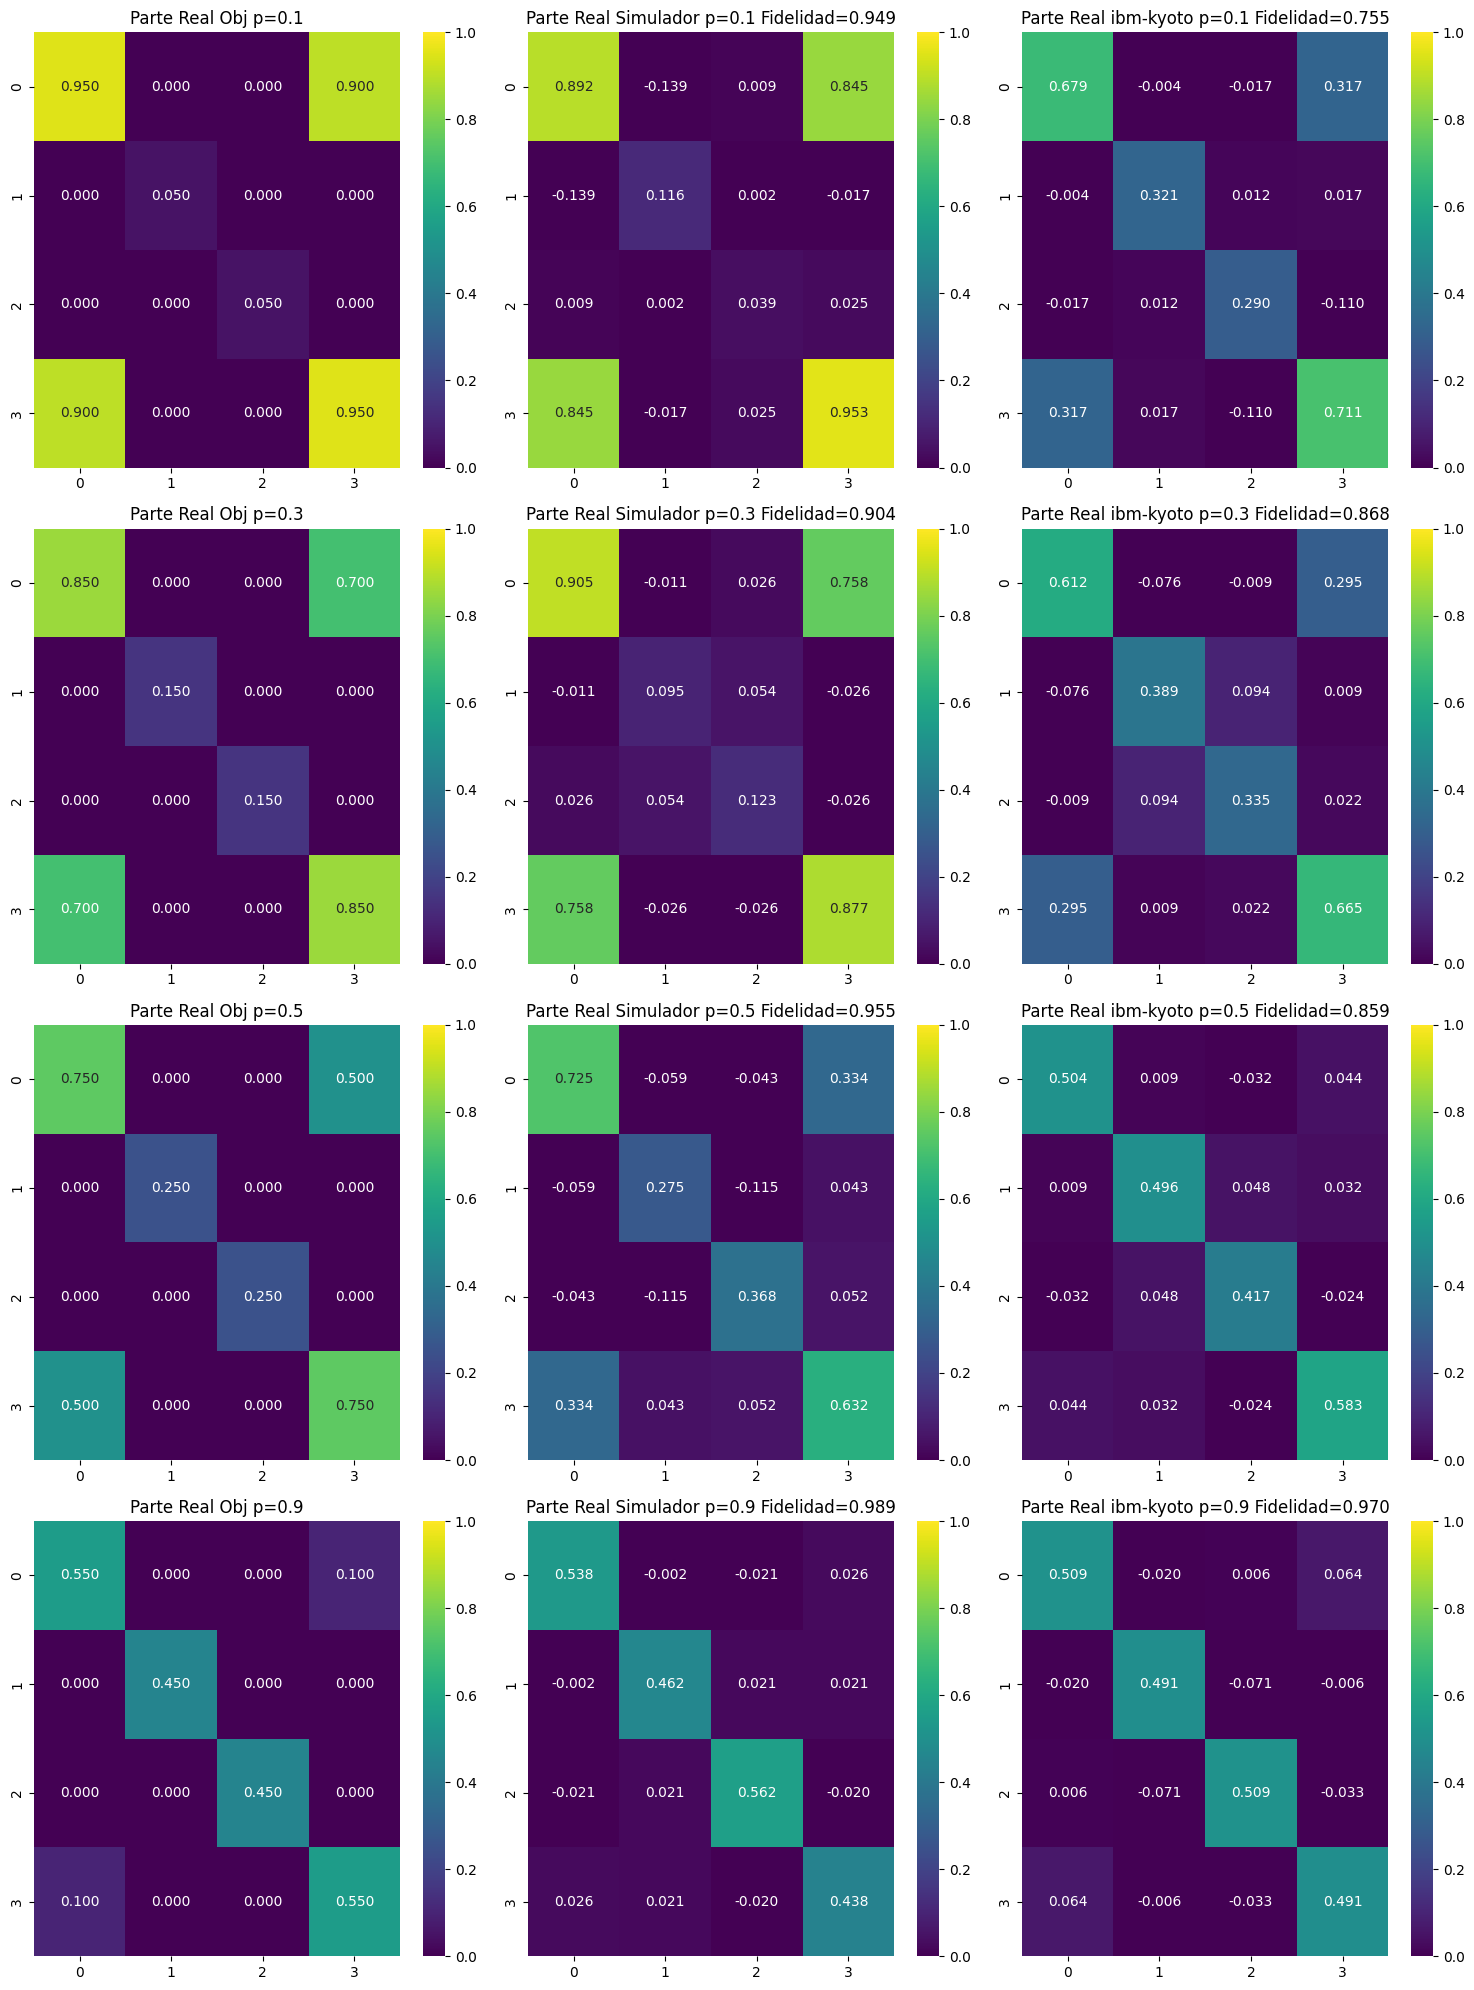

In [67]:
# Definimos los valores de p a graficar
p_values_to_plot = [0.1, 0.3, 0.5, 0.9]
filtered_rows = df_depo[df_depo['p'].isin(p_values_to_plot)]

# Configuración de la figura
num_p = len(p_values_to_plot)
plt.figure(figsize=(15, 5 * num_p))

for idx, (index, row) in enumerate(filtered_rows.iterrows()):
    # Convertir las matrices de Choi a arrays reales
    real_part_obj = np.real(row['Choi_obj'])
    real_part_sim = np.real(row['Choi_sim_1'])
    real_part_qc = np.real(row['Choi_qc'])
    
    # Subplot para la matriz objetivo
    plt.subplot(num_p, 3, 3 * idx + 1)
    sns.heatmap(real_part_obj, annot=True, cmap='viridis', fmt=".3f", vmin=0, vmax=1)
    plt.title(f'Parte Real Obj p={row["p"]}')
    
    # Subplot para la matriz del simulador
    plt.subplot(num_p, 3, 3 * idx + 2)
    sns.heatmap(real_part_sim, annot=True, cmap='viridis', fmt=".3f", vmin=0, vmax=1)
    plt.title(f'Parte Real Simulador p={row["p"]} Fidelidad={row["Fidelidad_sim_1"]:.3f}')
    
    # Subplot para la matriz de la computadora cuántica
    plt.subplot(num_p, 3, 3 * idx + 3)
    sns.heatmap(real_part_qc, annot=True, cmap='viridis', fmt=".3f", vmin=0, vmax=1)
    plt.title(f'Parte Real ibm-kyoto p={row["p"]} Fidelidad={row["Fidelidad_qc"]:.3f}')
    
plt.tight_layout()
plt.show()

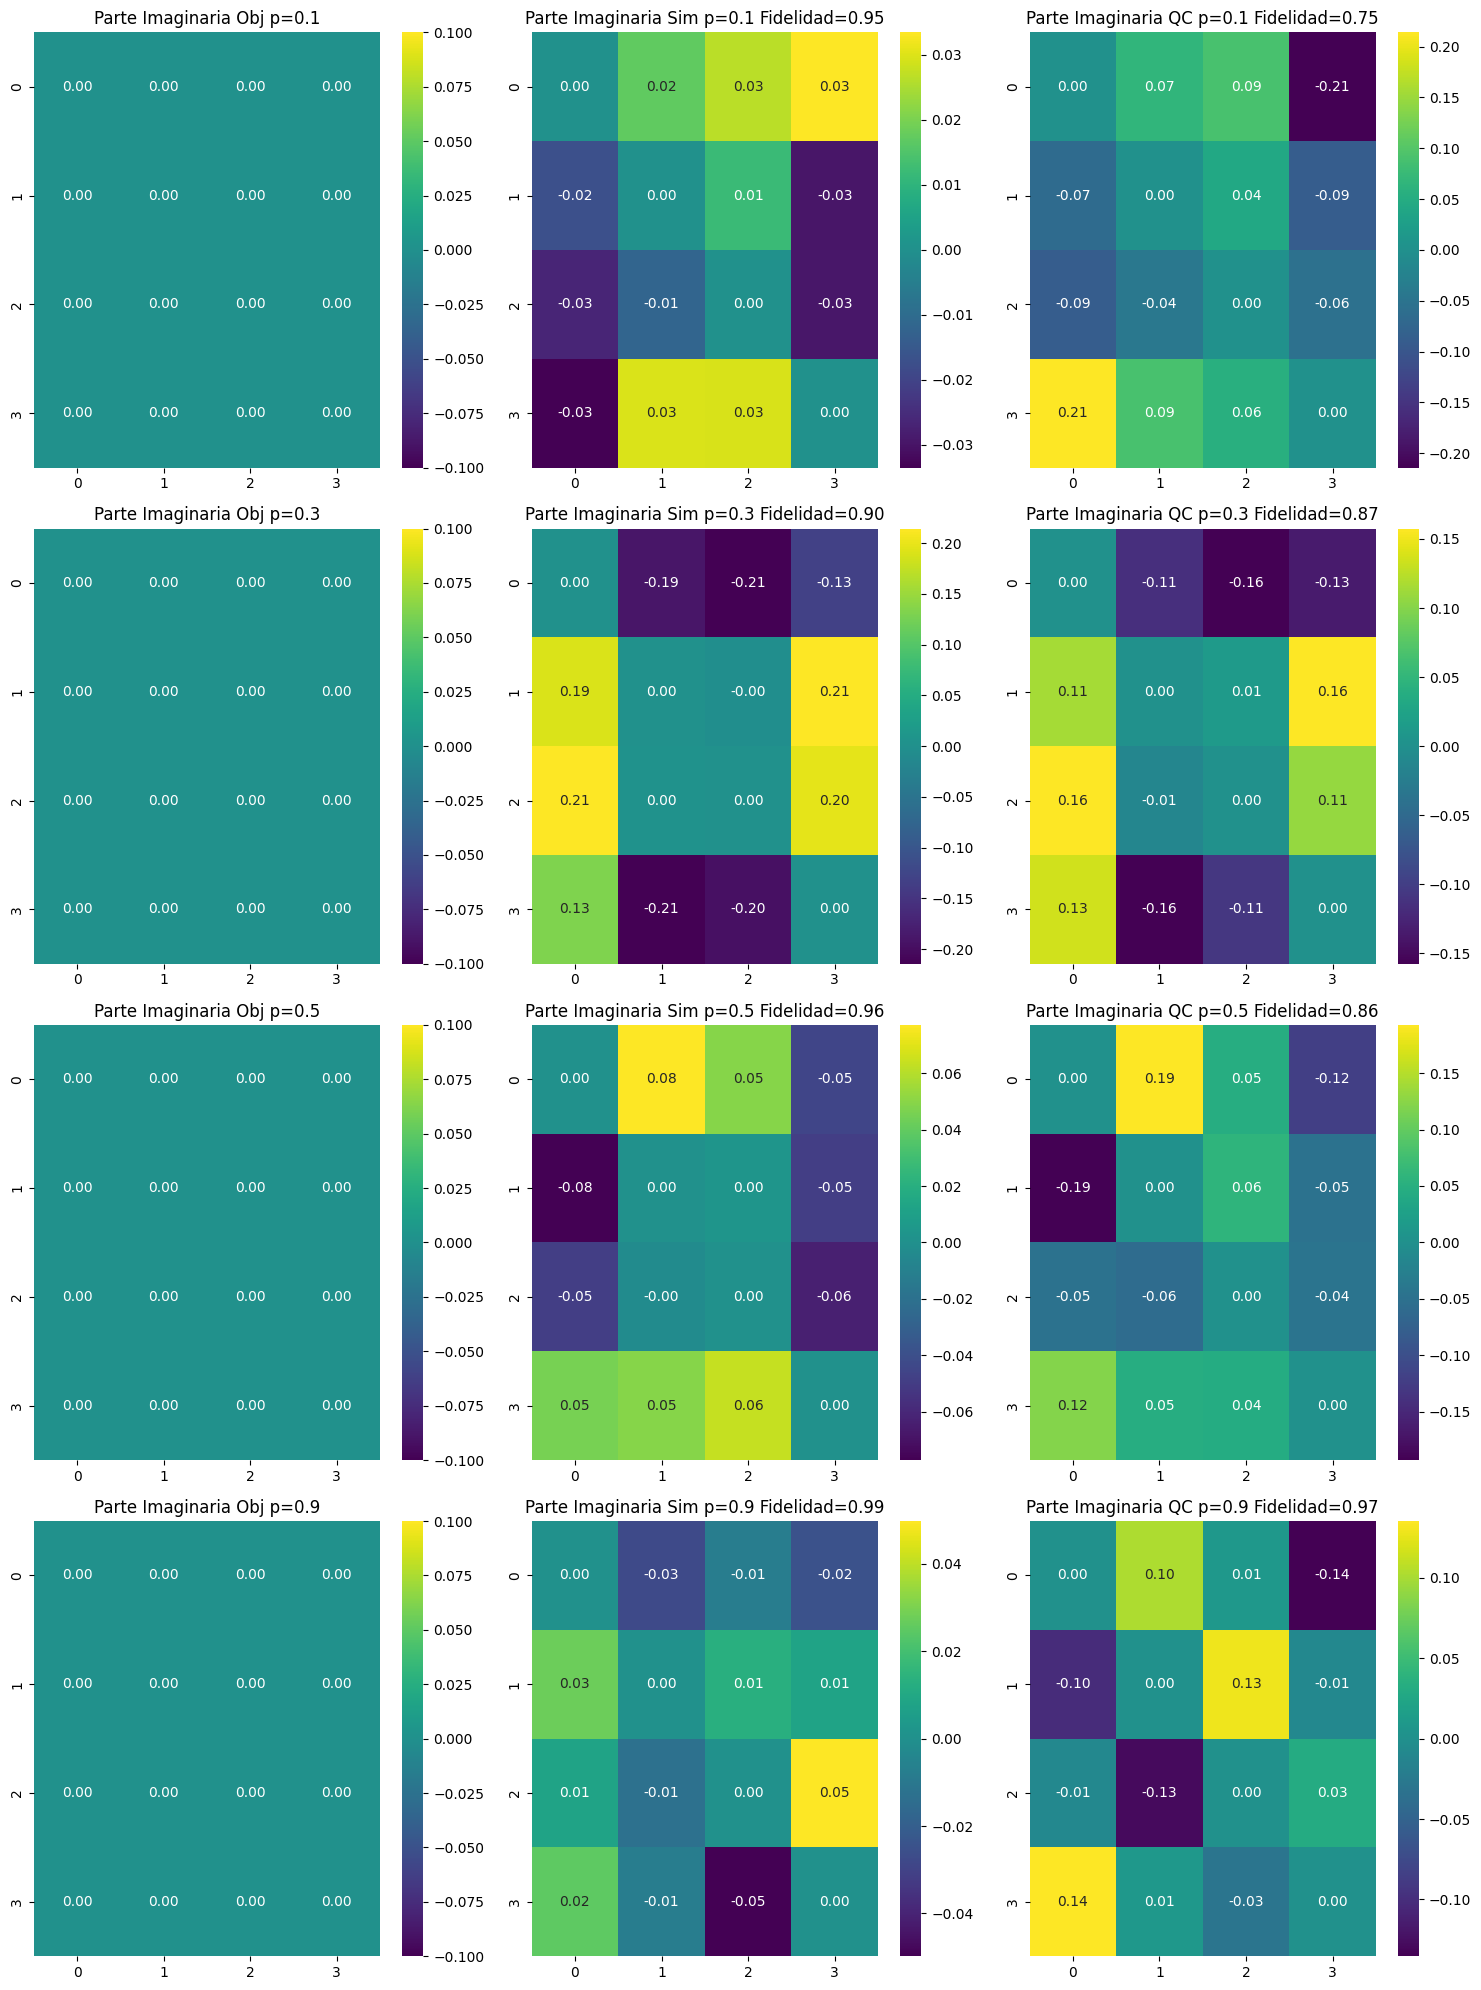

In [17]:
# Definimos los valores de p a graficar
p_values_to_plot = [0.1, 0.3, 0.5, 0.9]
filtered_rows = df_depo[df_depo['p'].isin(p_values_to_plot)]

# Configuración de la figura
num_p = len(p_values_to_plot)
plt.figure(figsize=(15, 5 * num_p))

for idx, (index, row) in enumerate(filtered_rows.iterrows()):
    # Convertir las matrices de Choi a arrays imaginarios
    imag_part_obj = np.imag(row['Choi_obj'])
    imag_part_sim = np.imag(row['Choi_sim_1'])
    imag_part_qc = np.imag(row['Choi_qc'])
    
    # Subplot para la matriz objetivo - Parte Imaginaria
    plt.subplot(num_p, 3, 3 * idx + 1)
    sns.heatmap(imag_part_obj, annot=True, cmap='viridis', fmt=".2f")
    plt.title(f'Parte Imaginaria Obj p={row["p"]}')
    
    # Subplot para la matriz del simulador - Parte Imaginaria
    plt.subplot(num_p, 3, 3 * idx + 2)
    sns.heatmap(imag_part_sim, annot=True, cmap='viridis', fmt=".2f")
    plt.title(f'Parte Imaginaria Sim p={row["p"]} Fidelidad={row["Fidelidad_sim_1"]:.2f}')
    
    # Subplot para la matriz de la computadora cuántica - Parte Imaginaria
    plt.subplot(num_p, 3, 3 * idx + 3)
    sns.heatmap(imag_part_qc, annot=True, cmap='viridis', fmt=".2f")
    plt.title(f'Parte Imaginaria QC p={row["p"]} Fidelidad={row["Fidelidad_qc"]:.2f}')
    
plt.tight_layout()
plt.show()

In [4]:
# Calcular y graficar los Autovalores de las matrices de Choi para distintos p
# Calcular y graficar los Autovalores de las matrices de Choi para distintos p
p_values = df_depo["p"]

# Diccionarios para almacenar los Autovalores y sus desviaciones estándar
eigenvalues_obj = {p: [] for p in p_values}
eigenvalues_sim = {p: [] for p in p_values}
eigenvalues_sim_std = {p: [] for p in p_values}
eigenvalues_qc = {p: [] for p in p_values}

for p in p_values:
    choi_matrix_obj = df_depo[df_depo['p'] == p]['Choi_obj'].values[0]
    choi_matrix_sim_1 = df_depo[df_depo['p'] == p]['Choi_sim_1'].values[0]
    choi_matrix_sim_2 = df_depo[df_depo['p'] == p]['Choi_sim_2'].values[0]
    choi_matrix_sim_3 = df_depo[df_depo['p'] == p]['Choi_sim_3'].values[0]
    choi_matrix_sim_4 = df_depo[df_depo['p'] == p]['Choi_sim_4'].values[0]
    choi_matrix_qc = df_depo[df_depo['p'] == p]['Choi_qc'].values[0]
    
    # Calcular Autovalores
    eigenvalues_obj[p] = np.linalg.eigvalsh(choi_matrix_obj)
    eigenvalues_sim_all = np.array([
        np.linalg.eigvalsh(choi_matrix_sim_1),
        np.linalg.eigvalsh(choi_matrix_sim_2),
        np.linalg.eigvalsh(choi_matrix_sim_3),
        np.linalg.eigvalsh(choi_matrix_sim_4)
    ])
    eigenvalues_sim[p] = np.mean(eigenvalues_sim_all, axis=0)
    eigenvalues_sim_std[p] = np.std(eigenvalues_sim_all, axis=0)
    eigenvalues_qc[p] = np.linalg.eigvalsh(choi_matrix_qc)

# Número de Autovalores a graficar
num_eigenvalues = len(eigenvalues_obj[p_values[0]])

# Aumentar el tamaño de los labels de los ejes
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

# Configurar la figura para que tenga un diseño 2x2
plt.figure(figsize=(18, 12))  # Aumentar el tamaño de la figura

# Crear subplots en una disposición 2x2
for i in range(num_eigenvalues):
    plt.subplot(2, 2, i + 1)  # Configuración 2x2
    plt.plot(p_values, [eigenvalues_obj[p][i] for p in p_values], 'b', label='Autovalores Choi Depolarizing', alpha=0.6, linestyle='-')
    plt.errorbar(p_values, [eigenvalues_sim[p][i] for p in p_values],
                 yerr=[eigenvalues_sim_std[p][i] for p in p_values], fmt='g', 
                 label='Autovalores Choi Simulador (Promedio)', alpha=0.6, linestyle='-',
                 capsize=5, capthick=1, elinewidth=1)
    plt.plot(p_values, [eigenvalues_qc[p][i] for p in p_values], 'r', label='Autovalores Choi Computadora Cuántica', alpha=0.6, linestyle='-')
    plt.xlabel('Probabilidad de Depolarización (p)', fontsize=14)
    plt.ylabel(f'Eigenvalor {i+1}', fontsize=14)
    plt.title(f'Comparación de Autovalores {i+1} en función de p', fontsize=16)
    plt.legend(fontsize='small')  # Reducir el tamaño de la leyenda
    plt.grid(True)

# Ajustar el espaciado entre subplots
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Aumentar espacio entre subplots

plt.tight_layout()
plt.show()

NameError: name 'df_depo' is not defined

C:\Users\felip\AppData\Local\Temp\ipykernel_10336\2768461760.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(p_values, [eigenvalues_obj[p][i] for p in p_values], 'b-o', label='Autovalores Choi Depolarizing', alpha=0.6, linestyle='--')
C:\Users\felip\AppData\Local\Temp\ipykernel_10336\2768461760.py:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "g-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(p_values, [eigenvalues_sim[p][i] for p in p_values],
C:\Users\felip\AppData\Local\Temp\ipykernel_10336\2768461760.py:9: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-^" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(p_values, [eigenvalues_qc[p][i] for p in p_values], 'r-^', label='Autoval

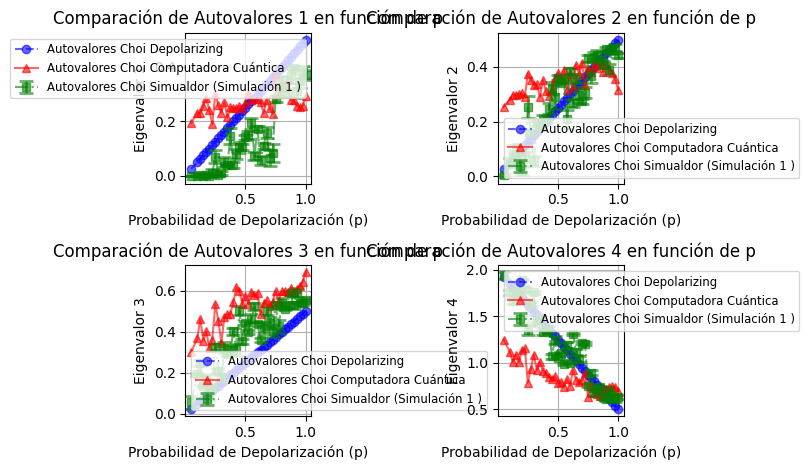